In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings

# Ignore warnings for clean output
warnings.filterwarnings('ignore')

# Matplotlib settings
%matplotlib inline
sns.set(style="whitegrid")


Loading Raw data ```data.csv``` data

In [3]:
df = pd.read_csv('data/raw/data.csv')
df.head()

,Patient ID,Age,Gender,Blood Pressure,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Symptoms,Medical History,Diagnosis,Admission Date
0,1,82,Male,127/80,56.0,33.6,100,20,Headache,Stroke,Hypertension,2023-05-06
1,2,58,Other,121/83,NaN,37.5,99,12,Fatigue,NaN,Healthy,2023-01-04
2,3,59,Other,121/85,78.0,36.5,90,15,Cough,COVID-19,Asthma,2023-10-10
3,4,21,Female,145/96,89.0,37.0,97,20,Chest Pain,Hypertension,Stroke,2023-05-17
4,5,30,Male,128/78,69.0,37.4,90,15,Chest Pain,COVID-19,Hypertension,2023-02-03


### Preprocessing

In [4]:
# Splitting Blood Pressure into two separate columns: Systolic and Diastolic
df[['Systolic BP', 'Diastolic BP']] = df['Blood Pressure'].str.split('/', expand=True)

# Convert Systolic and Diastolic BP to numeric
df['Systolic BP'] = pd.to_numeric(df['Systolic BP'], errors='coerce')
df['Diastolic BP'] = pd.to_numeric(df['Diastolic BP'], errors='coerce')

# Dropping the old 'Blood Pressure' column
df = df.drop('Blood Pressure', axis=1)

# Converting 'Admission Date' to datetime
df['Admission Date'] = pd.to_datetime(df['Admission Date'])

# One-Hot Encoding for 'Gender' and 'Symptoms'
df = pd.get_dummies(df, columns=['Gender', 'Symptoms' ,'Medical History' ,'Diagnosis' ], drop_first=True)

# Show the modified DataFrame
df.head()

,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Diabetes,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke
0,1,82,56.0,33.6,100,20,2023-05-06,127,80,True,...,False,False,False,True,False,False,False,False,True,False
1,2,58,NaN,37.5,99,12,2023-01-04,121,83,False,...,False,False,False,False,False,False,False,True,False,False
2,3,59,78.0,36.5,90,15,2023-10-10,121,85,False,...,False,False,False,False,False,False,False,False,False,False
3,4,21,89.0,37.0,97,20,2023-05-17,145,96,False,...,False,False,True,False,False,False,False,False,False,True
4,5,30,69.0,37.4,90,15,2023-02-03,128,78,True,...,False,False,False,False,False,False,False,False,True,False


### **Plotting**
 - The preprocessed data

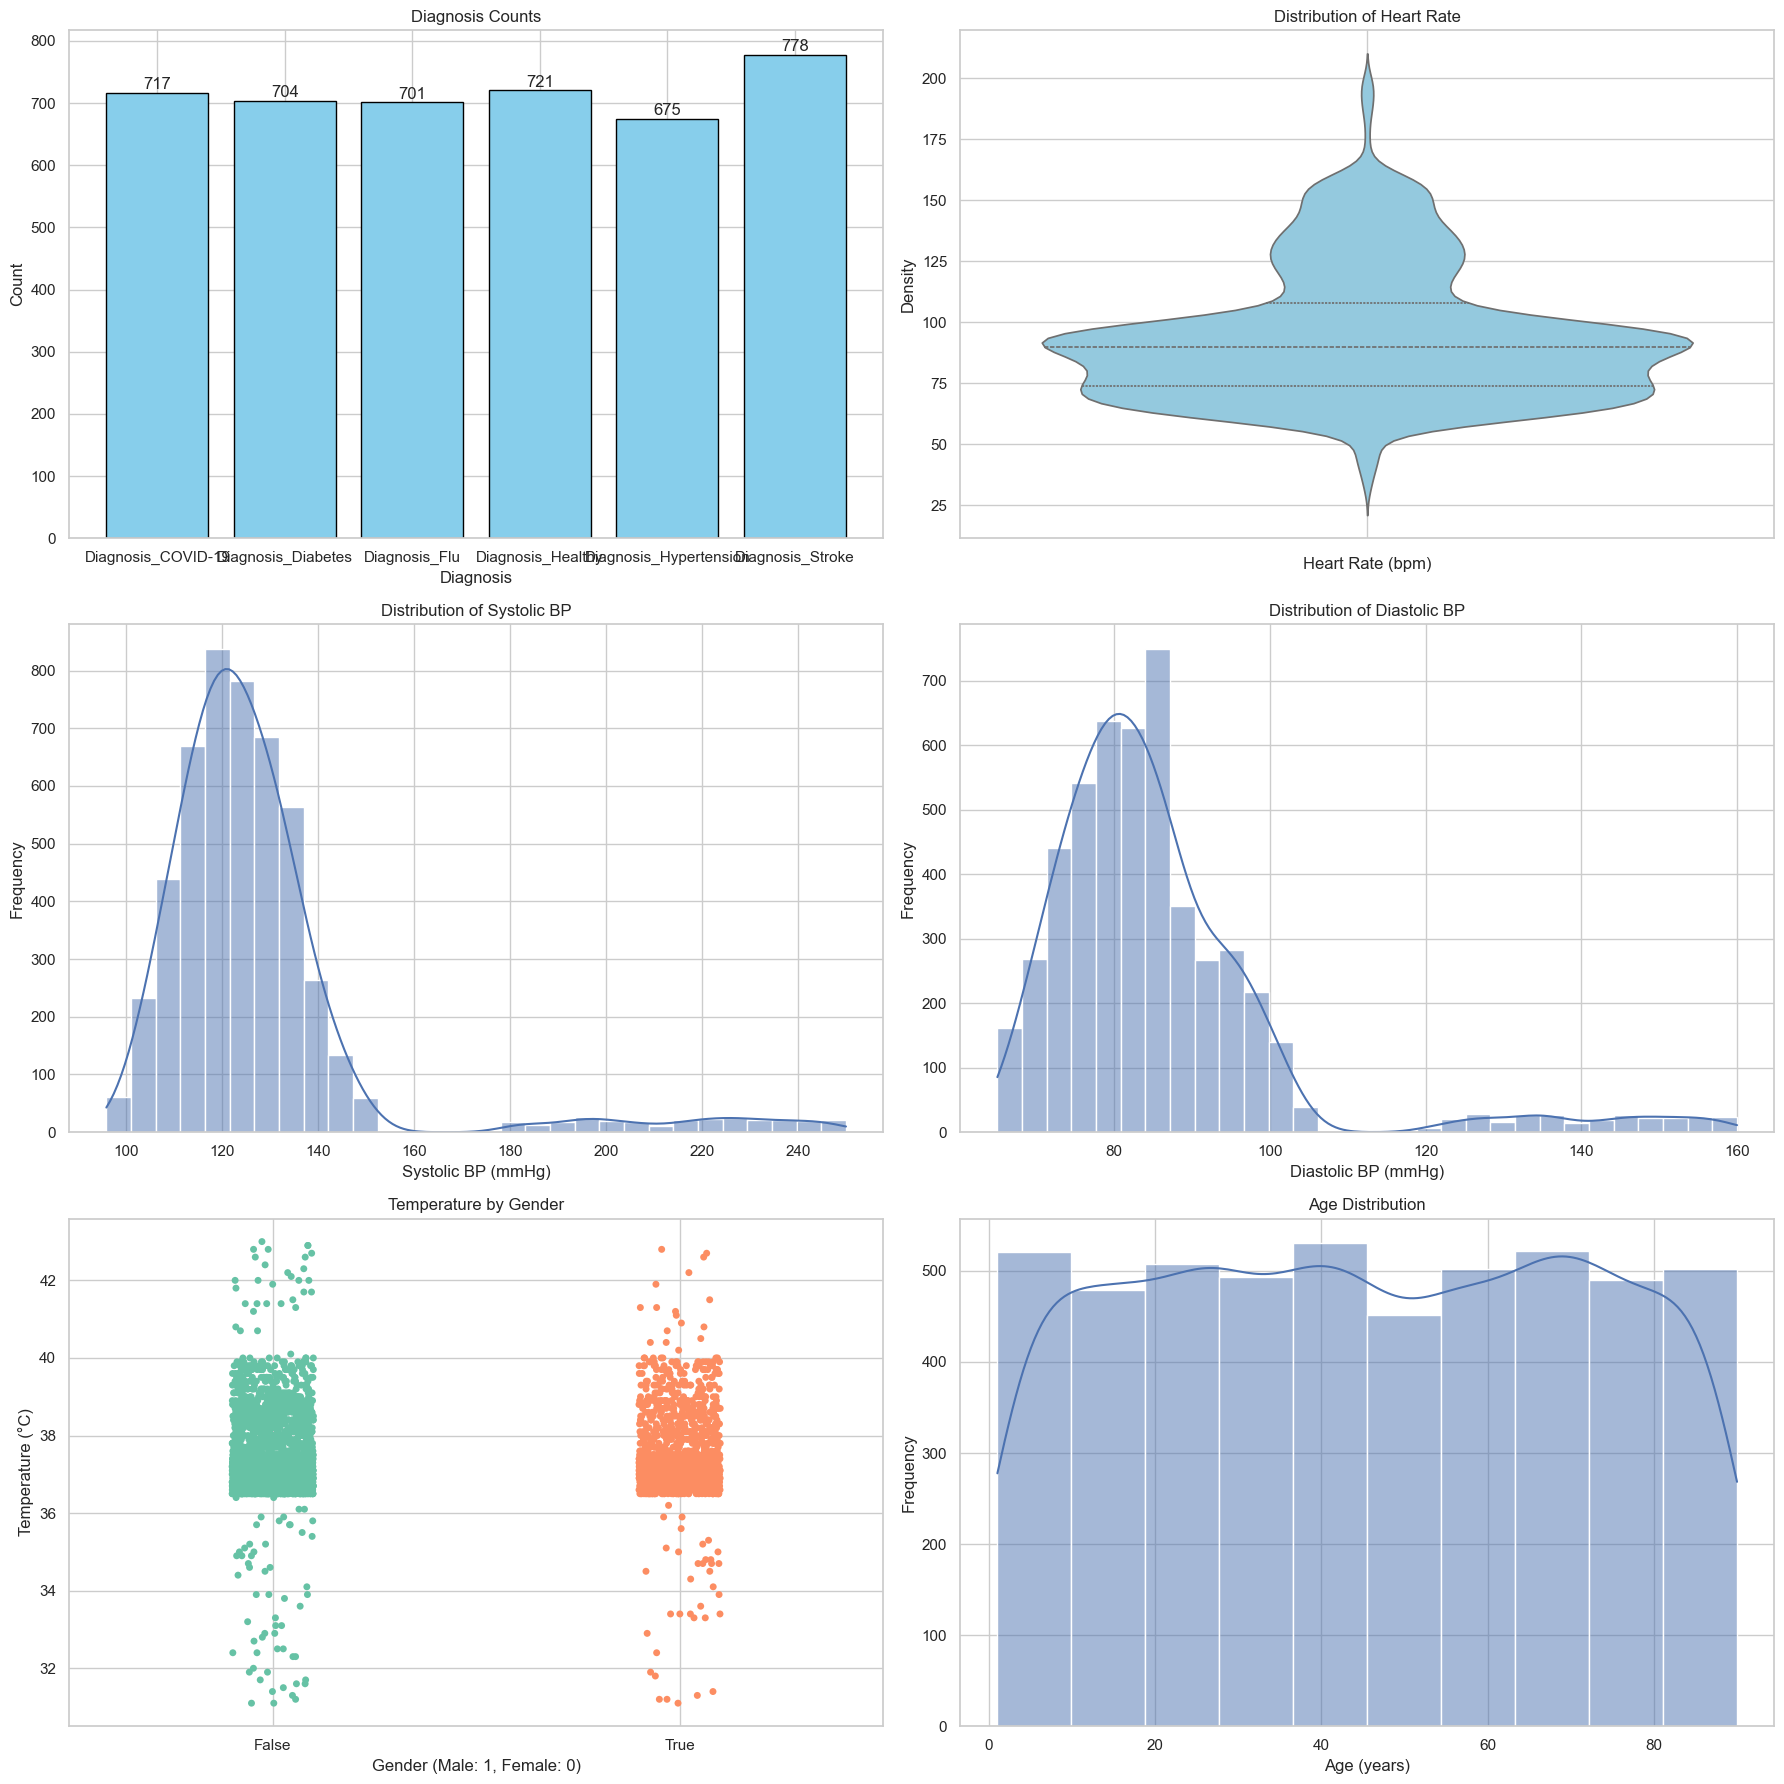

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.dates import DateFormatter

# DataFrame = df
df['Admission Date'] = pd.to_datetime(df['Admission Date'])
df = df.sort_values('Admission Date')

fig, axs = plt.subplots(3, 2, figsize=(18, 18))

# Diagnosis Counts ka Bar Plot
diagnosis_columns = ['Diagnosis_COVID-19', 'Diagnosis_Diabetes', 'Diagnosis_Flu', 'Diagnosis_Healthy', 'Diagnosis_Hypertension', 'Diagnosis_Stroke']
diagnosis_counts = df[diagnosis_columns].sum()

bars = axs[0, 0].bar(diagnosis_counts.index, diagnosis_counts.values, color='skyblue', edgecolor='black')
axs[0, 0].set_title('Diagnosis Counts')
axs[0, 0].set_xlabel('Diagnosis')
axs[0, 0].set_ylabel('Count')
axs[0, 0].grid(True)
for bar in bars:
    yval = bar.get_height()
    axs[0, 0].text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

# Heart Rate ka Violin Plot
sns.violinplot(y='Heart Rate', data=df, ax=axs[0, 1], inner='quartile', color='skyblue')
axs[0, 1].set_title('Distribution of Heart Rate')
axs[0, 1].set_xlabel('Heart Rate (bpm)')
axs[0, 1].set_ylabel('Density')
axs[0, 1].grid(True)

# Systolic BP ka histogram
sns.histplot(df['Systolic BP'].dropna(), bins=30, kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Systolic BP')
axs[1, 0].set_xlabel('Systolic BP (mmHg)')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].grid(True)

# Diastolic BP ka histogram
sns.histplot(df['Diastolic BP'].dropna(), bins=30, kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of Diastolic BP')
axs[1, 1].set_xlabel('Diastolic BP (mmHg)')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].grid(True)

# Temperature by Gender ka plot
sns.stripplot(x='Gender_Male', y='Temperature', data=df, ax=axs[2, 0], jitter=True, palette='Set2')
axs[2, 0].set_title('Temperature by Gender')
axs[2, 0].set_xlabel('Gender (Male: 1, Female: 0)')
axs[2, 0].set_ylabel('Temperature (°C)')
axs[2, 0].grid(True)

# Age Distribution ka histogram
sns.histplot(df['Age'], bins=10, kde=True, ax=axs[2, 1])
axs[2, 1].set_title('Age Distribution')
axs[2, 1].set_xlabel('Age (years)')
axs[2, 1].set_ylabel('Frequency')
axs[2, 1].grid(True)

plt.tight_layout()
plt.show()


plot ka section khatam

### **Adding Emergency column**

,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
4557,4558,88,100.0,38.5,92,14,2023-01-01,139,89,True,...,False,False,False,True,False,False,False,False,False,0
1247,1248,24,78.0,37.3,94,16,2023-01-01,123,87,True,...,False,False,False,False,False,False,False,False,True,0
1169,1170,34,142.0,38.7,88,12,2023-01-01,112,82,False,...,False,False,False,True,False,False,False,False,False,1
2609,2610,80,132.0,38.1,100,20,2023-01-01,128,86,True,...,False,False,False,False,False,False,False,True,False,2
4975,4976,44,153.0,38.7,99,15,2023-01-01,121,74,False,...,False,False,False,False,False,False,False,False,True,1


In [12]:
# Function to classify emergency levels based on medical research
def classify_emergency(row):
    # Initialize emergency score
    emergency_score = 0
    
    # Blood Pressure (BP) based on ACC/AHA and ESC guidelines
    if row['Systolic BP'] >= 180 or row['Diastolic BP'] >= 120:
        emergency_score += 4  # Hypertensive crisis
    elif 160 <= row['Systolic BP'] < 180 or 100 <= row['Diastolic BP'] < 120:
        emergency_score += 3  # Severe Hypertension
    elif 140 <= row['Systolic BP'] < 160 or 90 <= row['Diastolic BP'] < 100:
        emergency_score += 2  # Hypertension Stage 2
    elif 130 <= row['Systolic BP'] < 140 or 80 <= row['Diastolic BP'] < 90:
        emergency_score += 1  # Hypertension Stage 1
    else:
        emergency_score += 0  # Normal BP
    
    # Heart Rate (HR) based on clinical guidelines
    if row['Heart Rate'] > 130:
        emergency_score += 3  # Severe Tachycardia
    elif 100 < row['Heart Rate'] <= 130:
        emergency_score += 2  # Moderate Tachycardia
    elif 60 < row['Heart Rate'] <= 100:
        emergency_score += 1  # Normal
    elif 40 <= row['Heart Rate'] < 60:
        emergency_score += 2  # Mild Bradycardia
    else:
        emergency_score += 4  # Severe Bradycardia
    
    # Temperature (Temp) based on IDSA and WHO guidelines
    if row['Temperature'] < 34.0:
        emergency_score += 4  # Severe Hypothermia
    elif 34.0 <= row['Temperature'] < 35.0:
        emergency_score += 3  # Hypothermia
    elif row['Temperature'] > 38.5:
        emergency_score += 2  # Severe Fever
    elif 37.5 < row['Temperature'] <= 38.5:
        emergency_score += 1  # Fever
    else:
        emergency_score += 0  # Normal Temp
    
    # Respiratory Rate (RR) based on ARDS and Sepsis definitions
    if row['Respiratory Rate'] > 30:
        emergency_score += 4  # Severe Respiratory Distress
    elif 24 < row['Respiratory Rate'] <= 30:
        emergency_score += 3  # Moderate Respiratory Distress
    elif 16 < row['Respiratory Rate'] <= 24:
        emergency_score += 2  # Mild Respiratory Distress
    elif 12 <= row['Respiratory Rate'] <= 16:
        emergency_score += 1  # Normal RR
    else:
        emergency_score += 4  # Respiratory Failure
    
    # Oxygen Saturation (SpO2) based on WHO and ATS guidelines
    if row['Oxygen Saturation'] < 85:
        emergency_score += 4  # Severe Hypoxemia
    elif 85 <= row['Oxygen Saturation'] < 90:
        emergency_score += 3  # Moderate Hypoxemia
    elif 90 <= row['Oxygen Saturation'] < 94:
        emergency_score += 2  # Mild Hypoxemia
    else:
        emergency_score += 0  # Normal Oxygen Saturation
    
    # Return emergency level based on the total emergency score
    if emergency_score >= 12:
        return 'Very Critical'
    elif 8 <= emergency_score < 12:
        return 'High'
    elif 4 <= emergency_score < 8:
        return 'Medium'
    else:
        return 'Low'

# Applying the function to classify emergency levels
df['Emergency_Level'] = df.apply(classify_emergency, axis=1)

# Convert Emergency_Level to numerical for the ML model
df['Emergency_Level'] = df['Emergency_Level'].map({'Low': 0, 'Medium': 1, 'High': 2, 'Very Critical': 3})

# Display the updated DataFrame with emergency levels
df.head(50)


,Patient ID,Age,Heart Rate,Temperature,Oxygen Saturation,Respiratory Rate,Admission Date,Systolic BP,Diastolic BP,Gender_Male,...,Medical History_Heart Disease,Medical History_Hypertension,Medical History_Stroke,Diagnosis_COVID-19,Diagnosis_Diabetes,Diagnosis_Flu,Diagnosis_Healthy,Diagnosis_Hypertension,Diagnosis_Stroke,Emergency_Level
4557,4558,88,100.0,38.5,92,14,2023-01-01,139,89,True,...,False,False,False,True,False,False,False,False,False,1
1247,1248,24,78.0,37.3,94,16,2023-01-01,123,87,True,...,False,False,False,False,False,False,False,False,True,0
1169,1170,34,142.0,38.7,88,12,2023-01-01,112,82,False,...,False,False,False,True,False,False,False,False,False,2
2609,2610,80,132.0,38.1,100,20,2023-01-01,128,86,True,...,False,False,False,False,False,False,False,True,False,1
4975,4976,44,153.0,38.7,99,15,2023-01-01,121,74,False,...,False,False,False,False,False,False,False,False,True,1
2017,2018,22,73.0,36.7,92,12,2023-01-01,101,65,False,...,False,False,False,False,False,False,False,False,False,1
2880,2881,2,65.0,36.6,93,16,2023-01-01,113,67,False,...,False,False,False,False,True,False,False,False,False,1
1731,1732,29,60.0,37.0,90,12,2023-01-01,119,79,False,...,False,False,False,False,False,False,False,False,True,1
2892,2893,39,NaN,37.2,93,12,2023-01-01,130,83,True,...,False,False,False,False,False,False,False,True,False,2
694,695,60,98.0,38.6,98,18,2023-01-01,120,81,False,...,False,False,True,False,False,False,False,True,False,1
